In [41]:
import os
import gc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [42]:
root_dir = os.path.dirname(os.path.abspath(os.getcwd()))
pd.set_option("display.max_rows", 20, "display.max_columns", None)
plt.rcParams["figure.figsize"] = (12, 8)
sns.set_style("darkgrid")

In [43]:
train_df = pd.read_csv(os.path.join(root_dir, "data", "train.csv"))
building_df = pd.read_csv(os.path.join(root_dir, "data", "building_metadata.csv"))
weather_train_df = pd.read_csv(os.path.join(root_dir, "data", "weather_train.csv"), parse_dates = ["timestamp"])
weather_test_df = pd.read_csv(os.path.join(root_dir, "data", "weather_test.csv"), parse_dates = ["timestamp"])

weather_df = pd.concat((weather_train_df, weather_test_df), axis = 0).reset_index(drop = True)

del weather_train_df, weather_test_df

In [44]:
weather_df.head()

,site_id,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
0,0,2016-01-01 00:00:00,25.0,6.0,20.0,NaN,1019.7,0.0,0.0
1,0,2016-01-01 01:00:00,24.4,NaN,21.1,-1.0,1020.2,70.0,1.5
2,0,2016-01-01 02:00:00,22.8,2.0,21.1,0.0,1020.2,0.0,0.0
3,0,2016-01-01 03:00:00,21.1,2.0,20.6,0.0,1020.1,0.0,0.0
4,0,2016-01-01 04:00:00,20.0,2.0,20.0,-1.0,1020.0,250.0,2.6


In [45]:
weather_df.tail()

,site_id,timestamp,air_temperature,cloud_coverage,dew_temperature,precip_depth_1_hr,sea_level_pressure,wind_direction,wind_speed
417011,15,2018-12-31 19:00:00,3.3,NaN,1.7,NaN,1018.3,150.0,7.7
417012,15,2018-12-31 20:00:00,2.8,NaN,1.1,NaN,1017.8,140.0,5.1
417013,15,2018-12-31 21:00:00,2.8,NaN,1.7,-1.0,1017.2,140.0,6.2
417014,15,2018-12-31 22:00:00,2.8,NaN,2.2,8.0,1016.1,140.0,5.1
417015,15,2018-12-31 23:00:00,3.3,NaN,2.2,20.0,1014.7,140.0,5.1


In [46]:
key = ["site_id", "timestamp"]
air_temp_df = weather_df[key + ["air_temperature"]].drop_duplicates(subset = key).sort_values(by = key).copy()

In [47]:
air_temp_df.head()

,site_id,timestamp,air_temperature
0,0,2016-01-01 00:00:00,25.0
1,0,2016-01-01 01:00:00,24.4
2,0,2016-01-01 02:00:00,22.8
3,0,2016-01-01 03:00:00,21.1
4,0,2016-01-01 04:00:00,20.0


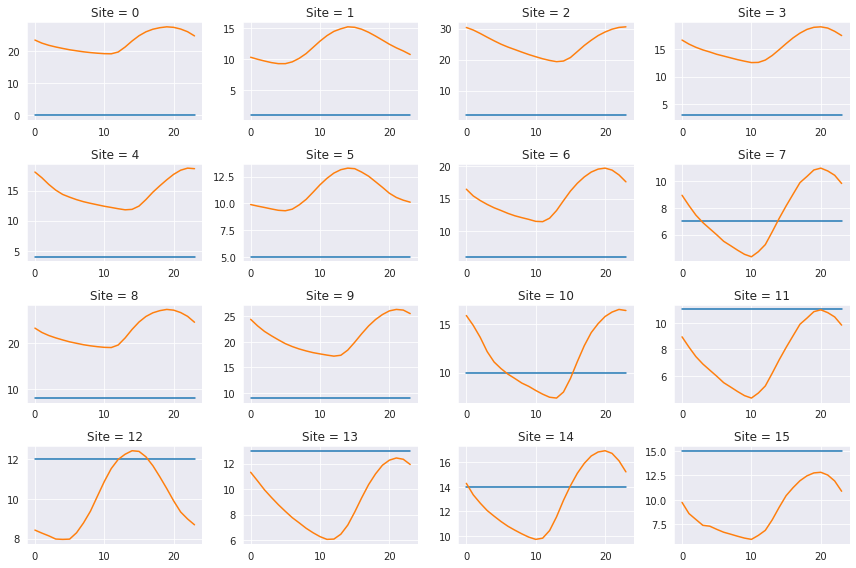

In [48]:
plot_data = air_temp_df.copy()
plot_data["hour"] = plot_data["timestamp"].dt.hour
count = 1

for site_id, site_data in plot_data.groupby("site_id"):
    site_by_hour = site_data.groupby("hour").mean()
    ax = plt.subplot(4, 4, count)
    plt.plot(site_by_hour)
    ax.set_title("Site = " + str(site_id))
    count += 1

plt.tight_layout()
plt.show()

del plot_data

In [49]:
# calculate ranks of hourly temperatures within data / site_id chunks
air_temp_df["rank"] = air_temp_df.groupby(["site_id", air_temp_df.timestamp.dt.date])["air_temperature"].rank("average")

# create a dataframe of site_ids (0-16) * mean hout rank of temperature within day (0-23)
df_2 = air_temp_df.groupby(["site_id", air_temp_df.timestamp.dt.hour])["rank"].mean().unstack(level = 1)

# subtract the columnID of temperature peak by 14, getting the timestamp alignment gap
# we are selecting 1400 hours as the peak time, so we are subtracting by 14
site_ids_offsets = pd.Series(df_2.values.argmax(axis = 1) - 14)
site_ids_offsets.index.name = "site_id"

In [50]:
def timestamp_align(df, offset_df):
    """
    aligns the timestamps
    
    inp: df with site and weather info; dataframe defining the offset
    """
    df["offset"] = df["site_id"].map(offset_df)
    df["timestamp_aligned"] = (df.timestamp - pd.to_timedelta(df.offset, unit = "H"))
    df["timestamp"] = df["timestamp_aligned"]
    del df["timestamp_aligned"]
    
    return df

In [51]:
# creating a dictionary of building_id mapping to respective site_id
building_site_dict = dict(zip(building_df["building_id"], building_df["site_id"]))

# mapping above created dictionary to train_df
site_meter_raw = train_df[["building_id", "meter", "timestamp", "meter_reading"]].copy()
site_meter_raw["site_id"] = site_meter_raw["building_id"].map(building_site_dict)

del site_meter_raw["building_id"]

In [52]:
site_plot_data = site_meter_raw.copy()
site_plot_data["timestamp"] = pd.to_datetime(site_plot_data["timestamp"])
site_plot_data["hour"] = site_plot_data["timestamp"].dt.hour
elec_meter_plot = site_plot_data[site_plot_data["meter"] == 0]

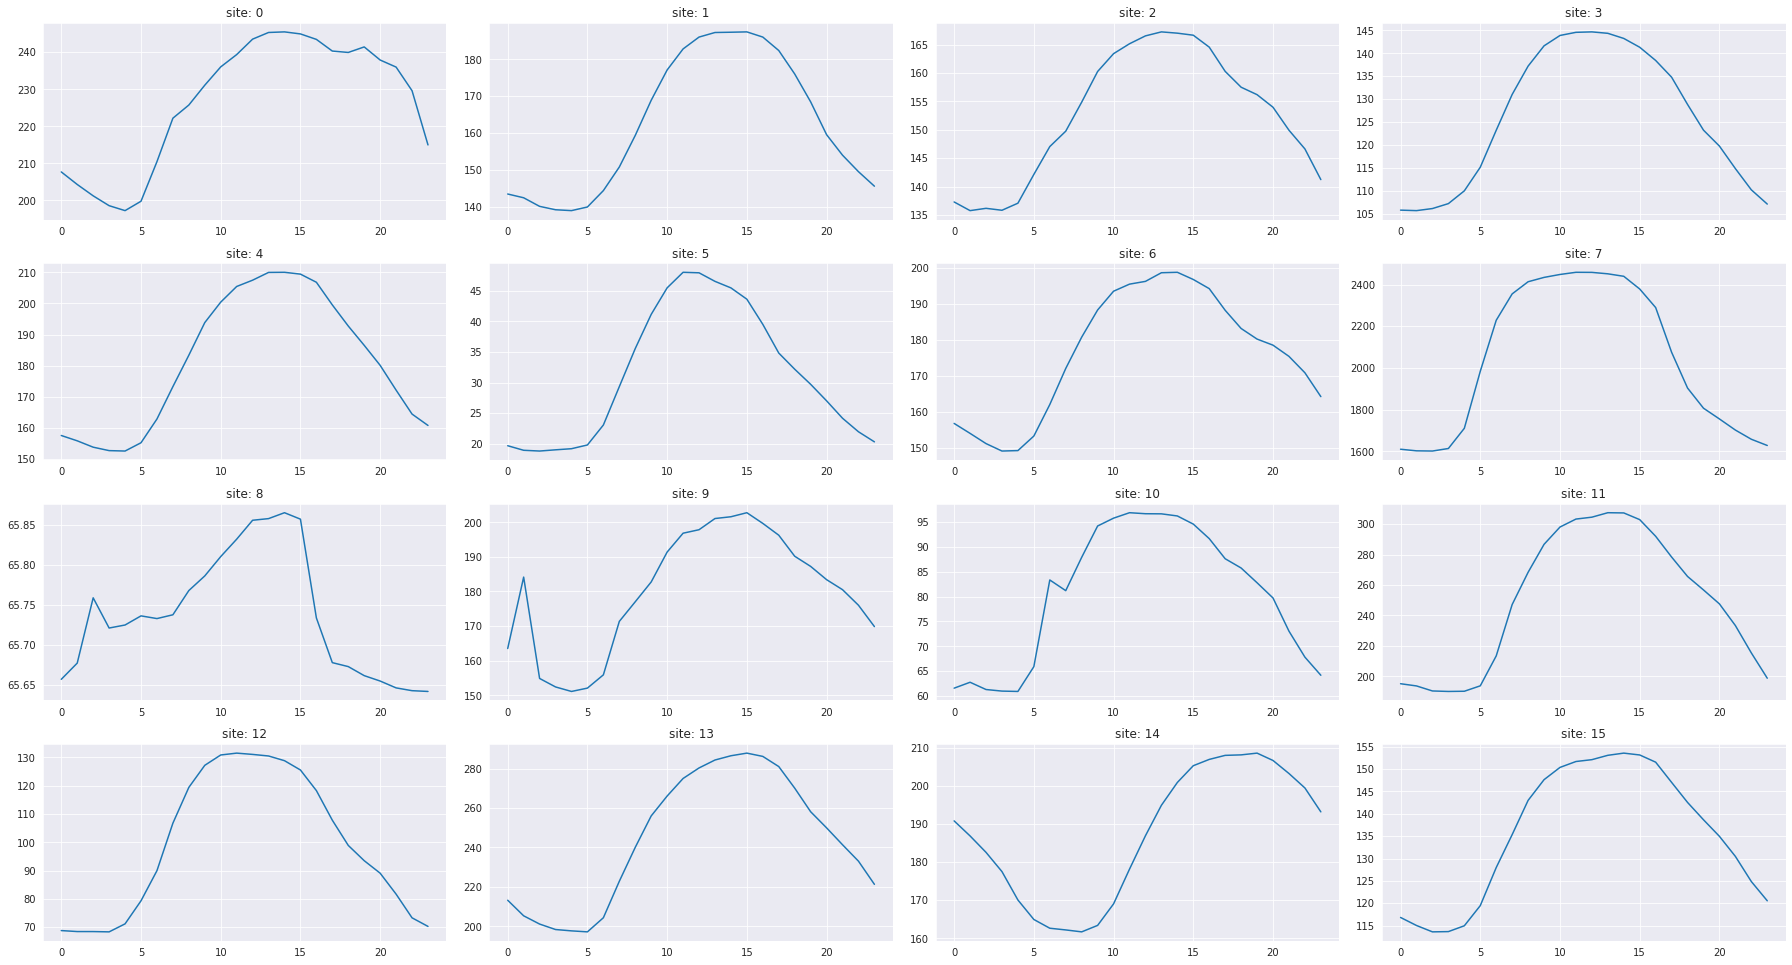

In [53]:
count = 1
plt.figure(figsize=(25, 50))

for site_id, site_data in elec_meter_plot.groupby("site_id"):
    site_by_hour = site_data.groupby("hour").mean()
    ax = plt.subplot(15, 4, count)
    plt.plot(site_by_hour.index, site_by_hour["meter_reading"])
    ax.set_title("site: " + str(site_id))
    count += 1
plt.tight_layout()
plt.show()

del elec_meter_plot, site_plot_data, building_site_dict, site_meter_raw

In [54]:
# preprocess -> timestamp_preprocess
# add_lag_features -> rolling_window_features

def timestamp_preprocess(df):
    """
    creates time derived features
    """
    df["hour"] = df["timestamp"].dt.hour
    df["weekend"] = df["timestamp"].dt.weekday
    df["month"] = df["timestamp"].dt.month
    df["dayofweek"] = df["timestamp"].dt.dayofweek
    
    return df

def rolling_window_feature(weather_df, window = 7):
    # group weather by site
    weather_site_df = weather_df.groupby("site_id")
    
    # selecting column for lag features 
    cols = ["air_temperature", "cloud_coverage", "dew_temperature", "precip_depth_1_hr", "sea_level_pressure", "wind_direction", "wind_speed"]
    rolled_obj = weather_site_df[cols].rolling(window = window, min_periods = 0)
    rolled_mean = rolled_obj.mean().reset_index().astype(np.float16)
    rolled_max = rolled_obj.max().reset_index().astype(np.float16)
    rolled_min = rolled_obj.min().reset_index().astype(np.float16)
    rolled_std = rolled_obj.std().reset_index().astype(np.float16)
    
    for col in cols:
        weather_df[f"{col}_rolled_mean_{window}"] = rolled_mean[col]
        weather_df[f"{col}_rolled_max_{window}"] = rolled_max[col]
        weather_df[f"{col}_rolled_min_{window}"] = rolled_min[col]
        weather_df[f"{col}_rolled_std_{window}"] = rolled_std[col]
    
    return weather_df   

In [55]:
train_df["timestamp"] = pd.to_datetime(train_df["timestamp"])

train_df["date"] = train_df["timestamp"].dt.date
train_df["meter_reading_log1p"] = np.log1p(train_df["meter_reading"])    # calculate natural-log + 1

# dropping meter = 0 whose data is not trustworthy before 2016-05-20
train_df = train_df.query('not (building_id <= 104 & meter == 0 & timestamp <= "2016-05-20")')
train_df = timestamp_preprocess(train_df)

train_grouped_obj = train_df.groupby("building_id")["meter_reading_log1p"]
building_mean = train_grouped_obj.mean().astype(np.float16)
building_max = train_grouped_obj.max().astype(np.float16)
building_min = train_grouped_obj.min().astype(np.float16)
building_std = train_grouped_obj.min().astype(np.float16)

# aligning the timestamp
weather_df = timestamp_align(weather_df, site_ids_offsets)
weather_df = weather_df.groupby("site_id").apply(lambda x: x.interpolate(limit_direction = "both"))

# create rolling features in weather dataset
weather_df = rolling_window_feature(weather_df, window = 7)   # weekly
weather_df = rolling_window_feature(weather_df, window = 30)  # monthly

primary_use_list = building_df["primary_use"].unique()
primary_use_dict = {key: value for value, key in enumerate(primary_use_list)}
print("primary_use_dict: {}".format(primary_use_dict))
building_df["primary_use"] = building_df["primary_use"].map(primary_use_dict)

gc.collect()

primary_use_dict: {'Education': 0, 'Lodging/residential': 1, 'Office': 2, 'Entertainment/public assembly': 3, 'Other': 4, 'Retail': 5, 'Parking': 6, 'Public services': 7, 'Warehouse/storage': 8, 'Food sales and service': 9, 'Religious worship': 10, 'Healthcare': 11, 'Utility': 12, 'Technology/science': 13, 'Manufacturing/industrial': 14, 'Services': 15}


0

In [61]:
weather_df.columns

Index(['site_id', 'timestamp', 'air_temperature', 'cloud_coverage',
       'dew_temperature', 'precip_depth_1_hr', 'sea_level_pressure',
       'wind_direction', 'wind_speed', 'offset',
       'air_temperature_rolled_mean_7', 'air_temperature_rolled_max_7',
       'air_temperature_rolled_min_7', 'air_temperature_rolled_std_7',
       'cloud_coverage_rolled_mean_7', 'cloud_coverage_rolled_max_7',
       'cloud_coverage_rolled_min_7', 'cloud_coverage_rolled_std_7',
       'dew_temperature_rolled_mean_7', 'dew_temperature_rolled_max_7',
       'dew_temperature_rolled_min_7', 'dew_temperature_rolled_std_7',
       'precip_depth_1_hr_rolled_mean_7', 'precip_depth_1_hr_rolled_max_7',
       'precip_depth_1_hr_rolled_min_7', 'precip_depth_1_hr_rolled_std_7',
       'sea_level_pressure_rolled_mean_7', 'sea_level_pressure_rolled_max_7',
       'sea_level_pressure_rolled_min_7', 'sea_level_pressure_rolled_std_7',
       'wind_direction_rolled_mean_7', 'wind_direction_rolled_max_7',
       'wind_

In [62]:
category_columns = ["building_id", "site_id", "primary_use"]
feature_columns_1 = ["square_feet", "year_built", "hour", "weekend"]
feature_columns_2 = ['air_temperature', 'cloud_coverage', 'dew_temperature', 'precip_depth_1_hr', 'sea_level_pressure', 'wind_direction', 'wind_speed',
                     'air_temperature_rolled_mean_7', 'air_temperature_rolled_max_7', 'air_temperature_rolled_min_7', 'air_temperature_rolled_std_7', 
                     'cloud_coverage_rolled_mean_7', 'cloud_coverage_rolled_max_7', 'cloud_coverage_rolled_min_7', 'cloud_coverage_rolled_std_7',
                     'dew_temperature_rolled_mean_7', 'dew_temperature_rolled_max_7', 'dew_temperature_rolled_min_7', 'dew_temperature_rolled_std_7', 
                     'precip_depth_1_hr_rolled_mean_7', 'precip_depth_1_hr_rolled_max_7', 'precip_depth_1_hr_rolled_min_7', 'precip_depth_1_hr_rolled_std_7', 
                     'sea_level_pressure_rolled_mean_7', 'sea_level_pressure_rolled_max_7', 'sea_level_pressure_rolled_min_7', 'sea_level_pressure_rolled_std_7', 
                     'wind_direction_rolled_mean_7', 'wind_direction_rolled_max_7', 'wind_direction_rolled_min_7', 'wind_direction_rolled_std_7', 
                     'wind_speed_rolled_mean_7', 'wind_speed_rolled_max_7', 'wind_speed_rolled_min_7', 'wind_speed_rolled_std_7', 
                     'air_temperature_rolled_mean_30', 'air_temperature_rolled_max_30', 'air_temperature_rolled_min_30', 'air_temperature_rolled_std_30', 
                     'cloud_coverage_rolled_mean_30', 'cloud_coverage_rolled_max_30', 'cloud_coverage_rolled_min_30', 'cloud_coverage_rolled_std_30', 
                     'dew_temperature_rolled_mean_30', 'dew_temperature_rolled_max_30', 'dew_temperature_rolled_min_30', 'dew_temperature_rolled_std_30', 
                     'precip_depth_1_hr_rolled_mean_30', 'precip_depth_1_hr_rolled_max_30', 'precip_depth_1_hr_rolled_min_30', 'precip_depth_1_hr_rolled_std_30',
                     'sea_level_pressure_rolled_mean_30', 'sea_level_pressure_rolled_max_30', 'sea_level_pressure_rolled_min_30', 
                     'sea_level_pressure_rolled_std_30', 'wind_direction_rolled_mean_30', 'wind_direction_rolled_max_30', 'wind_direction_rolled_min_30', 
                     'wind_direction_rolled_std_30', 'wind_speed_rolled_mean_30', 'wind_speed_rolled_max_30', 'wind_speed_rolled_min_30', 
                     'wind_speed_rolled_std_30']

feature_columns = feature_columns_1 + feature_columns_2

In [63]:
def train_target_set(df, weather_df, building_df, cat_cols = category_columns, feat_cols = feature_columns, meter = None):
    """
    divides the dataset into predictors and labels for a particular meter
    
    inp: df, meter (whose set is to be constructed)
    outp: predictor_df, label_df
    """
    target_df = df[train_df["meter"] == meter]
    target_df = target_df.merge(building_df, on = "building_id", how = "left")
    target_df = target_df.merge(weather_df, on = ["site_id", "timestamp"], how = "left")
    x_train = target_df[feat_cols + cat_cols]
    y_train = target_df["meter_reading_log1p"].values
    
    del target_df
    return x_train, y_train